In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
%matplotlib inline

In [2]:
clustered_masks_path = '/home/wences/Documents/GitRepos/FCNBudDetection/output/validation/0FCMN8rmsprop_lr0.0001_prep_mobilenet_ep150/clustered_masks/'
prediction_masks_path = '/home/wences/Documents/GitRepos/FCNBudDetection/output/validation/0FCMN8rmsprop_lr0.0001_prep_mobilenet_ep150/prediction_masks/'
source_images_path = '/home/wences/Documents/temp/dataset_resize/images_resize/'

In [3]:
per_sample_csv = pd.read_csv('metrics_cluster_0FCMN8rmsprop_lr0.0001_prep_mobilenet_ep150.csv')
ground_truth = pd.read_csv('single_instance_dataset_wradius.csv')
test_set_image_list = pd.read_csv('single_instance_test.csv')
test_set_image_list = test_set_image_list['imageOrigin'].values
ground_truth_test = ground_truth.loc[ground_truth['imageOrigin'].isin(test_set_image_list.tolist()), :]

Breve descripcion de las distancias obtenidas a traves de todos los thresholds

In [4]:
per_sample_csv.columns

Index(['Unnamed: 0', 'model_name', 'threshold', 'mask_name', 'eps',
       'min_samples', 'buds_predicted', 'true_positive_x', 'true_positive_y',
       'true_positive_distance', 'true_positive_norm_distance'],
      dtype='object')

In [5]:
per_sample_csv['true_positive_distance'].describe()

count    1085.000000
mean       21.173307
std        68.950301
min         0.052574
25%         2.590678
50%         4.582945
75%        12.596827
max       667.264613
Name: true_positive_distance, dtype: float64

Promedio y desviacion estandard de a cada threshold

In [6]:
per_sample_csv.pivot_table(values='true_positive_distance',index='threshold', aggfunc=[np.std, np.mean])

,std,mean
,true_positive_distance,true_positive_distance
threshold,,
0.1,91.017989,28.362975
0.2,71.207750,22.329351
0.3,76.064740,23.451907
0.4,76.515282,22.839205
0.5,54.959962,18.148381
0.6,60.774275,19.210449
0.7,68.263409,20.082605
0.8,55.752765,17.199034


Donde caen las yemas en las escenas que conforman el dataset?

<Figure size 288x360 with 0 Axes>

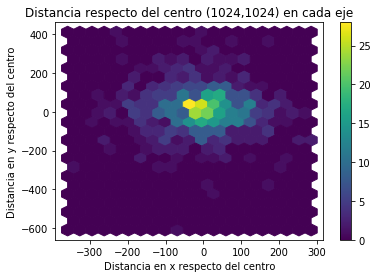

<Figure size 288x360 with 0 Axes>

In [7]:
plt.hexbin(x=ground_truth['x_center_resize'].values-1024,y=ground_truth['y_center_resize'].values-1024,gridsize=20)
plt.title('Distancia respecto del centro (1024,1024) en cada eje')
plt.ylabel('Distancia en y respecto del centro')
plt.xlabel('Distancia en x respecto del centro')
plt.colorbar()
plt.figure(figsize=(4,5))

Para el conjunto de testeo que pertenece al dataset:

In [8]:
ground_truth_test.columns

Index(['Unnamed: 0', 'imageOrigin', 'mask', 'patch_name', 'x_center_orig',
       'y_center_orig', 'x_center_resize', 'y_center_resize', 'diam_orig',
       'diam_resize'],
      dtype='object')

<Figure size 288x360 with 0 Axes>

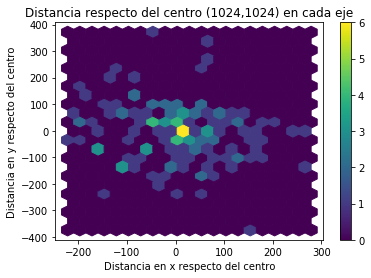

<Figure size 288x360 with 0 Axes>

In [9]:
plt.hexbin(x=ground_truth_test['x_center_resize'].values-1024,y=ground_truth_test['y_center_resize'].values-1024,gridsize=20)
plt.title('Distancia respecto del centro (1024,1024) en cada eje')
plt.ylabel('Distancia en y respecto del centro')
plt.xlabel('Distancia en x respecto del centro')
plt.colorbar()
plt.figure(figsize=(4,5))

Ahora como scatterplot

<Figure size 288x360 with 0 Axes>

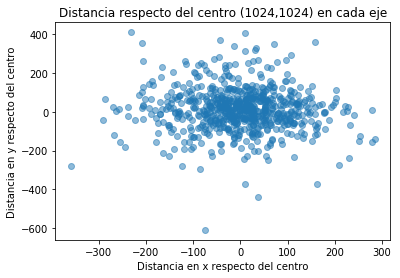

<Figure size 288x360 with 0 Axes>

In [10]:
plt.scatter(x=ground_truth['x_center_resize'].values-1024,y=ground_truth['y_center_resize'].values-1024, alpha=0.5)
plt.title('Distancia respecto del centro (1024,1024) en cada eje')
plt.ylabel('Distancia en y respecto del centro')
plt.xlabel('Distancia en x respecto del centro')
plt.figure(figsize=(4,5))

Para el conjunto de testeo que pertenece al dataset:

<Figure size 288x360 with 0 Axes>

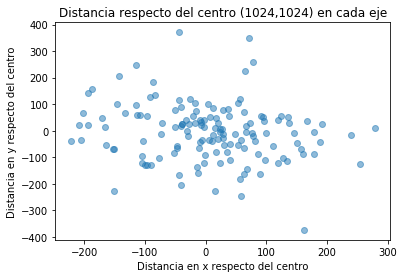

<Figure size 288x360 with 0 Axes>

In [11]:
plt.scatter(x=ground_truth_test['x_center_resize'].values-1024,y=ground_truth_test['y_center_resize'].values-1024, alpha=0.5)
plt.title('Distancia respecto del centro (1024,1024) en cada eje')
plt.ylabel('Distancia en y respecto del centro')
plt.xlabel('Distancia en x respecto del centro')
plt.figure(figsize=(4,5))

Cual es el diametro promedio de las yemas del dataset. (Dividido por 2 ya que la red se entrena con 1024x1024 y este csv que describe el dataset esta en 2048x2048)

In [12]:
ground_truth['diam_resize'].describe()

count    698.000000
mean     247.287658
std      162.381768
min       31.614458
25%      131.415205
50%      202.195448
75%      306.377510
max      963.368421
Name: diam_resize, dtype: float64

Para el conjunto de testeo que pertenece al dataset:

In [13]:
ground_truth_test['diam_resize'].describe()

count    140.000000
mean     227.442261
std      146.006064
min       50.506024
25%      124.810916
50%      178.042697
75%      286.672021
max      741.052632
Name: diam_resize, dtype: float64

Ahora dividamos los resultados en rangos de distancia y veamos cuantos centros de yema caen en cada bolsa. (Veamos que tan dispersas son las predicciones del modelo en cuanto a distancia normalizada)

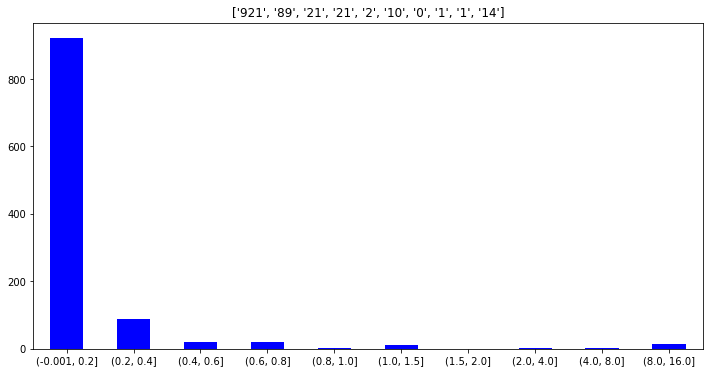

In [14]:
out = pd.cut(per_sample_csv['true_positive_norm_distance'].values, bins=[0,0.2,0.4,0.6,0.8,1,1.5,2,4,8,16], include_lowest=True)
out.value_counts().plot.bar(rot=0, color="b", figsize=(12,6))
plt.title([str(out.value_counts().values[i]) for i in range(out.value_counts().values.shape[0])]);

Numero de NaNs en todo el dataset y todos los thresholds, no yema detectada, imagen negra

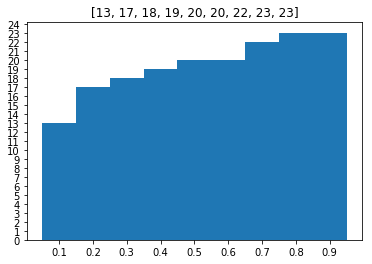

In [15]:
threshold_list = per_sample_csv['threshold'].unique()
nan_list = []
for threshold in threshold_list:
    th_df = per_sample_csv.loc[per_sample_csv['threshold'] == threshold,:]
    nan_list.append(th_df.loc[per_sample_csv['buds_predicted'] == 0,:].shape[0])
plt.bar(x=threshold_list, height=nan_list, align='center',tick_label=threshold_list,width=0.1, linewidth=2)
plt.yticks(np.arange(0,25,1))
plt.title(nan_list);

Numero de clusteres detectados en la mascara generada

In [16]:
per_sample_csv.pivot_table(values='buds_predicted',index='threshold', aggfunc=[np.sum])

,sum
,buds_predicted
threshold,
0.1,196
0.2,178
0.3,169
0.4,167
0.5,161
0.6,157
0.7,152
0.8,146


Visualizacion de 10 imagenes donde no se pudieron detectar yemas

In [17]:
w=10
h=10
columns = 4
rows = 5

In [18]:
temp = per_sample_csv.loc[(per_sample_csv['threshold'] == 0.5 )& (per_sample_csv['buds_predicted'] == 0),:]
img_list = temp['mask_name'].values

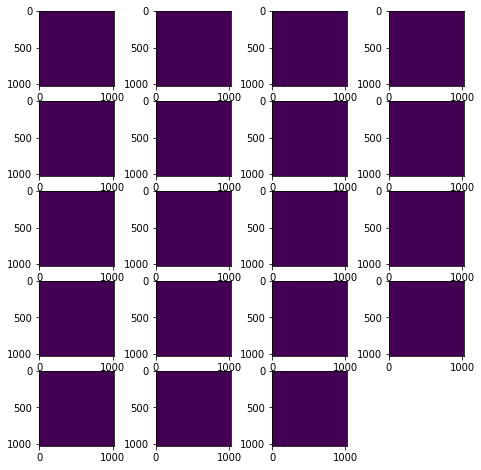

In [19]:
fig=plt.figure(figsize=(8, 8))
for i in range(1, columns*rows):
    img = plt.imread(os.path.join(prediction_masks_path,img_list[i-1]))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

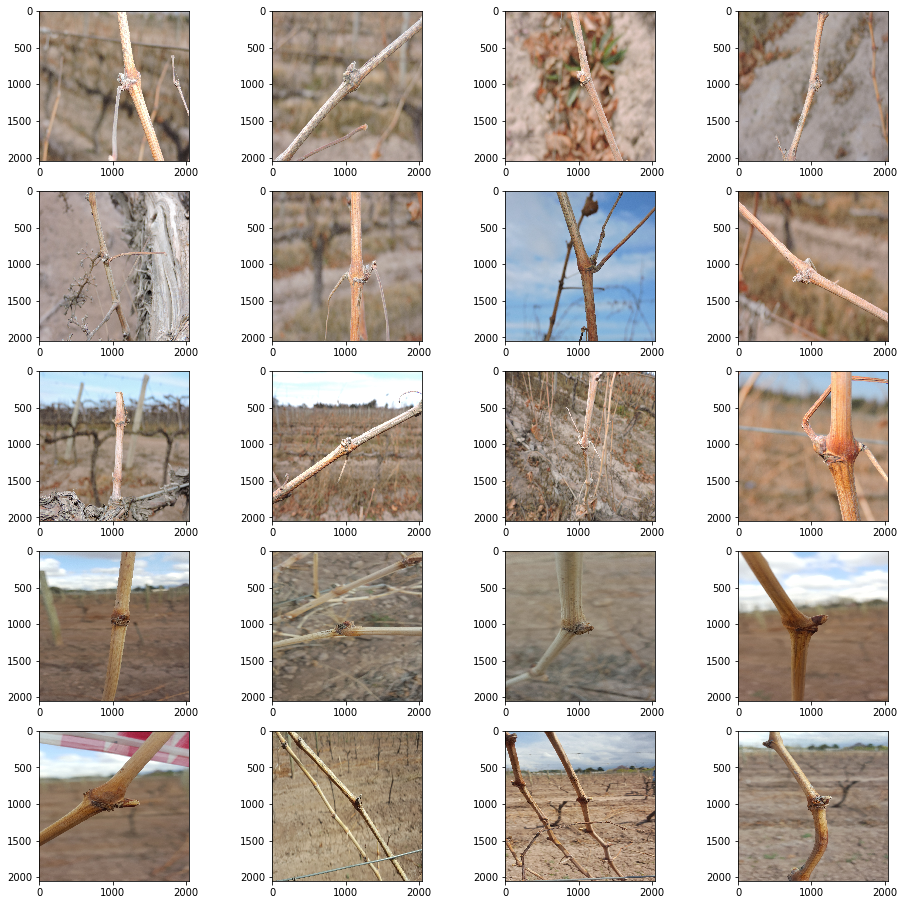

In [20]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, columns*rows):
    img = cv2.cvtColor(cv2.imread(os.path.join(source_images_path, img_list[i][3:8] + 'jpg')), cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

In [21]:
temp = per_sample_csv.loc[(per_sample_csv['threshold'] == 0.5 )& (per_sample_csv['buds_predicted'] == 1),:]
img_list = temp['mask_name'].values

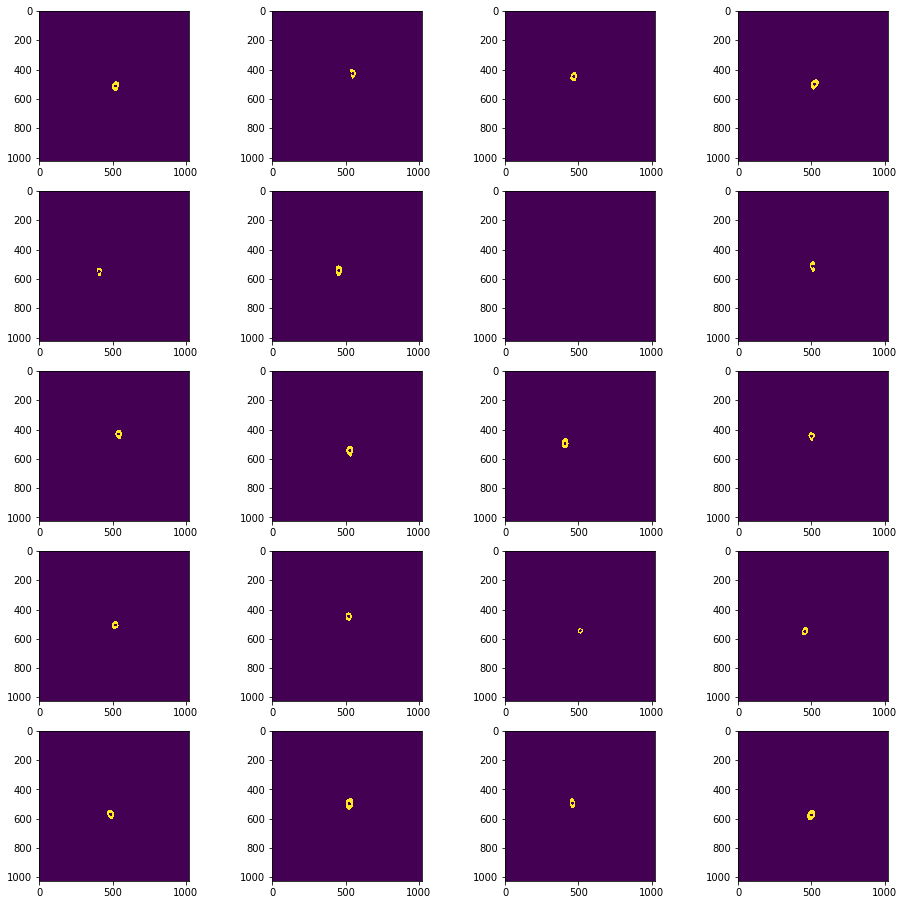

In [22]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, columns*rows):
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    img = plt.imread(os.path.join(prediction_masks_path,img_list[i]))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(cv2.circle(img, center=center, radius=10, color=(0,0,0),thickness=-1))
plt.show()

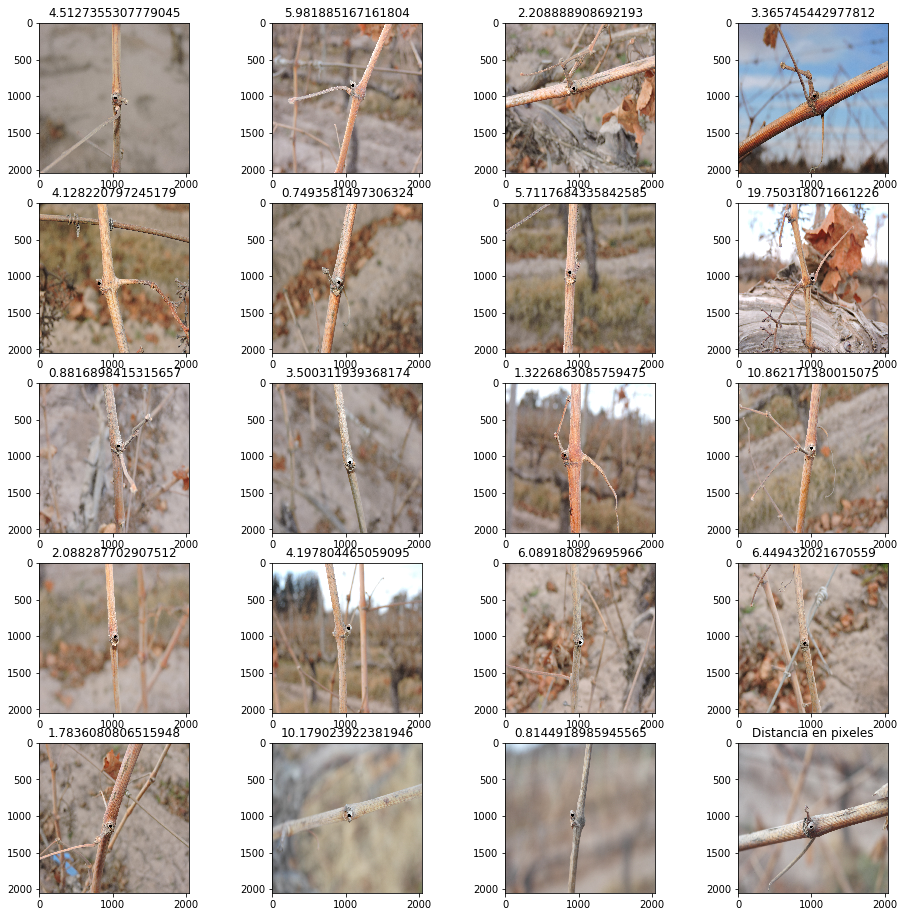

In [23]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, columns*rows):
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    img = cv2.cvtColor(cv2.imread(os.path.join(source_images_path, img_list[i][3:8] + 'jpg')), cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i+1, title=temp.iloc[i,:]['true_positive_distance'])
    plt.imshow(cv2.circle(img, center=tuple([2*x for x in center]), radius=20, color=(0,0,0),thickness=-1))
plt.title('Distancia en pixeles')
plt.show()

Veamos aquellas instancias sobre las que se detectaron varios clusters

In [24]:
temp = per_sample_csv.loc[(per_sample_csv['threshold'] == 0.5 )& (per_sample_csv['buds_predicted'] >= 2),:]
img_list = temp['mask_name'].values

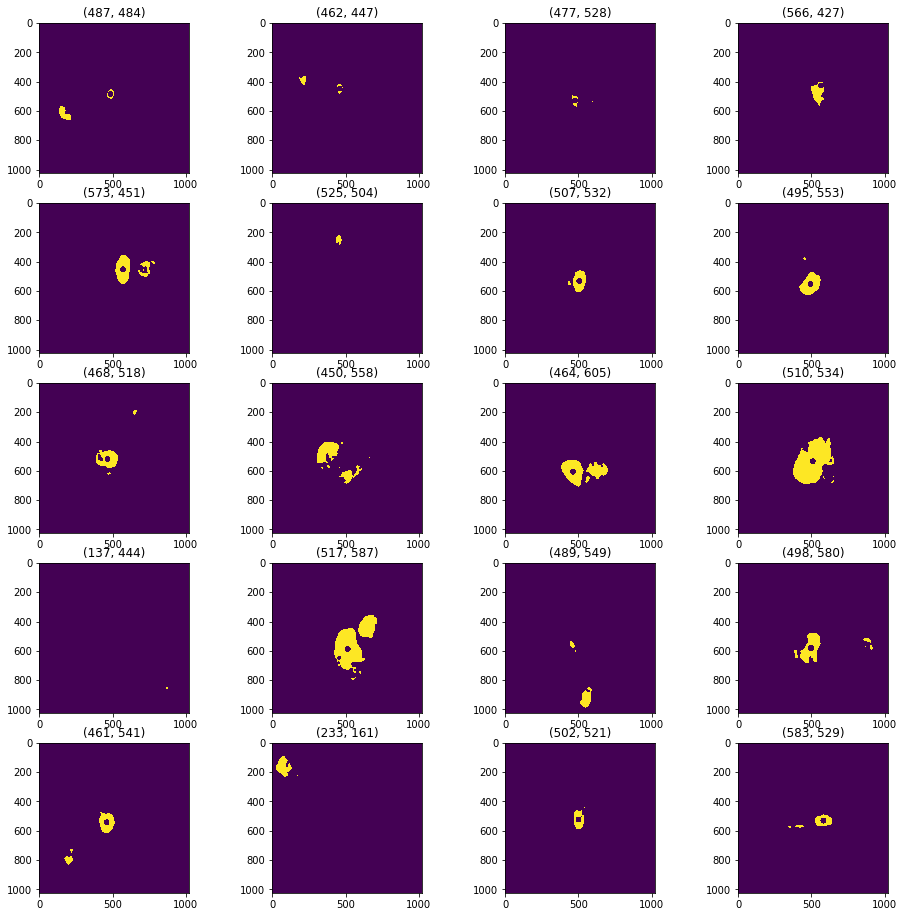

In [25]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, columns*rows):
    img = plt.imread(os.path.join(prediction_masks_path,img_list[i]))
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    fig.add_subplot(rows, columns, i+1, title=center)
    plt.imshow(cv2.circle(img, center=center, radius=20, color=(0,0,0),thickness=-1))
plt.show()

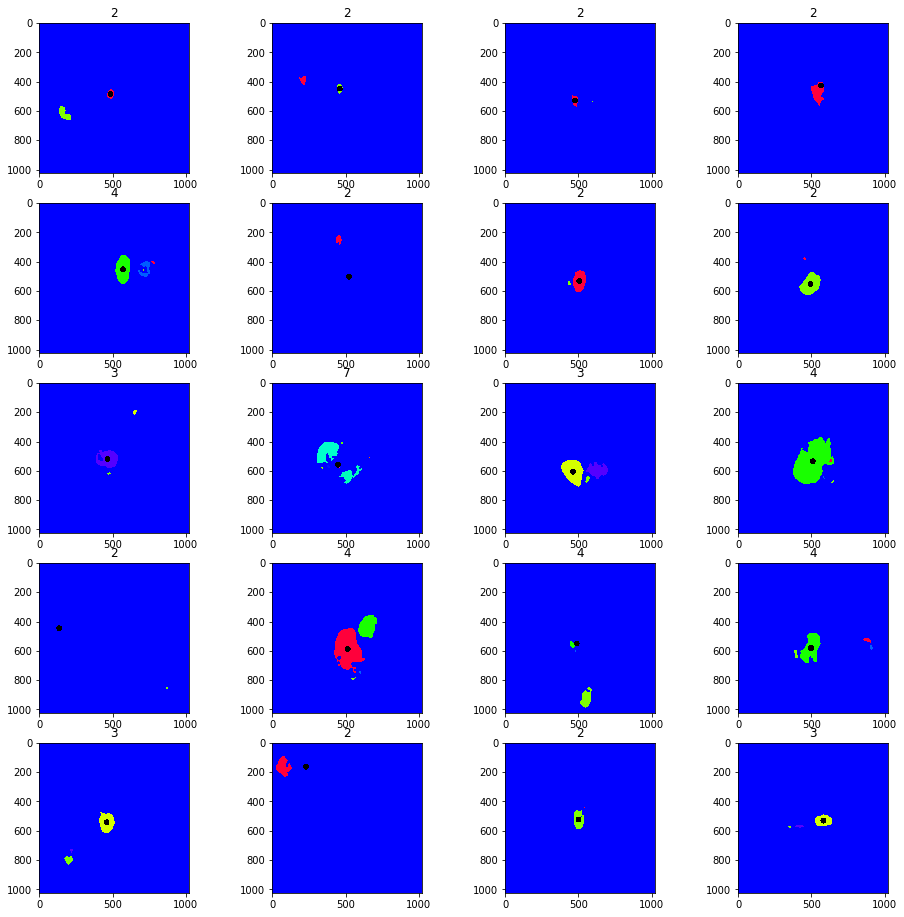

In [27]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, columns*rows):
    img = plt.imread(os.path.join(clustered_masks_path,'cluster_'+img_list[i]))
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    fig.add_subplot(rows, columns, i+1, title=temp.iloc[i,:]['buds_predicted'])
    plt.imshow(cv2.circle(img, center=center, radius=20, color=(0,0,0),thickness=-1))
plt.show()

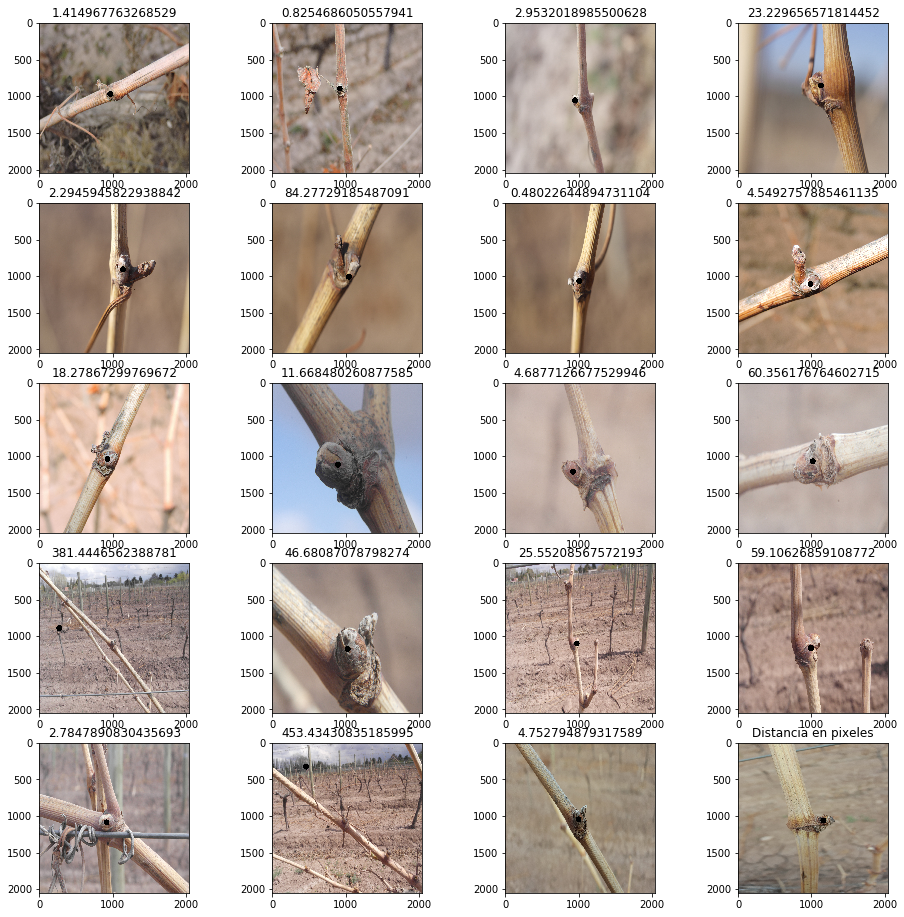

In [28]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, columns*rows):
    img = cv2.cvtColor(cv2.imread(os.path.join(source_images_path, img_list[i][3:8] + 'jpg')), cv2.COLOR_BGR2RGB)
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    fig.add_subplot(rows, columns, i+1, title=temp.iloc[i,:]['true_positive_distance'])
    plt.imshow(cv2.circle(img, center=tuple([2*x for x in center]), radius=40, color=(0,0,0),thickness=-1))
plt.title('Distancia en pixeles')
plt.show()

Veamos los casos en los que la distancia euclideana normalizada fue mayor a un diametro de yema [th = 0.5]

In [29]:
temp = per_sample_csv.loc[(per_sample_csv['threshold'] == 0.5 )& (per_sample_csv['true_positive_norm_distance'] >= 1),:]
img_list = temp['mask_name'].values
temp.shape

(2, 11)

In [30]:
w=10
h=10
columns = 2
rows = 1

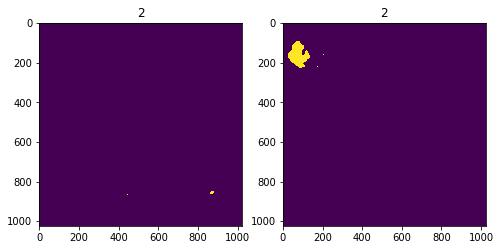

In [33]:
fig=plt.figure(figsize=(8, 16))
for i in range(0, columns*rows):
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    img = plt.imread(os.path.join(prediction_masks_path,img_list[i]))
    fig.add_subplot(rows, columns, i+1, title=temp.iloc[i,:]['buds_predicted'])
    plt.imshow(cv2.circle(img, center=center, radius=15, color=(0,0,0),thickness=-1))
plt.show()


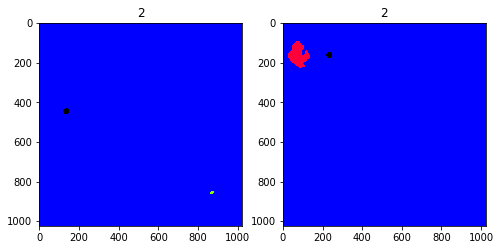

In [35]:
fig=plt.figure(figsize=(8, 16))
for i in range(0, columns*rows):
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    img = plt.imread(os.path.join(clustered_masks_path,'cluster_'+img_list[i]))
    fig.add_subplot(rows, columns, i+1, title=temp.iloc[i,:]['buds_predicted'])
    plt.imshow(cv2.circle(img, center=center, radius=15, color=(0,0,0),thickness=-1))
plt.show()

In [ ]:
fig=plt.figure(figsize=(8, 16))
for i in range(0, columns*rows):
    img = cv2.cvtColor(cv2.imread(os.path.join(source_images_path, img_list[i][3:8] + 'jpg')), cv2.COLOR_BGR2RGB)
    center = (int(temp.iloc[i-1,:]['true_positive_x']), int(temp.iloc[i-1,:]['true_positive_y']))
    fig.add_subplot(rows, columns, i+1, title=temp.iloc[i-1,:]['true_positive_distance'])
    plt.imshow(cv2.circle(img, center=tuple([2*x for x in center]), radius=40, color=(0,0,0),thickness=-1))
plt.show()